In [1]:
import os.path
from IPython.display import Image

from util import Util
u = Util()

import numpy as np
# Explicit random seed for reproducibility
np.random.seed(1337)  

Using TensorFlow backend.


In [2]:
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.layers import Merge
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K

In [3]:
from keras.datasets import mnist

In [4]:
batch_size = 512
nb_classes = 10
nb_epoch = 650
# checkpoint path
checkpoints_dir = "checkpoints"

# number of networks for ensamble learning
number_of_models = 5

In [5]:
# input image dimensions
img_rows, img_cols = 28, 28
# number of convolutional filters to use
nb_filters1 = 20
nb_filters2 = 40
# size of pooling area for max pooling
pool_size1 = (2, 2)
pool_size2 = (3, 3)
# convolution kernel size
kernel_size1 = (4, 4)
kernel_size2 = (5, 5)
# dense layer size
dense_layer_size1 = 200
# dropout rate
dropout = 0.15
# activation type
activation = 'relu'

In [6]:
# the data, shuffled and split between train and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()

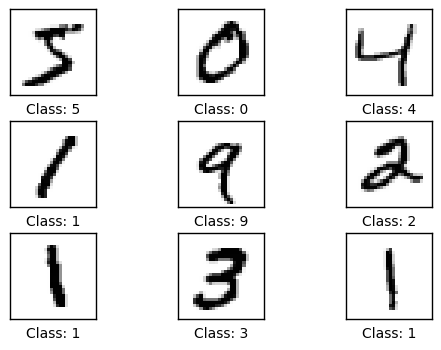

In [7]:
u.plot_images(X_train[0:9], y_train[0:9])

In [8]:
if K.image_dim_ordering() == 'th':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

In [9]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

X_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [10]:
# convert class vectors to binary class matrices
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

In [11]:
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=False)

# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
datagen.fit(X_train)

In [12]:
def initialize_network(model, dropout1=dropout, dropout2=dropout, loss='categorical_crossentropy'):
    model.add(Convolution2D(nb_filters1, kernel_size1[0], kernel_size1[1],
                            border_mode='valid',
                            input_shape=input_shape, name='covolution_1_' + str(nb_filters1) + '_filters'))
    model.add(Activation(activation, name='activation_1_' + activation))
    model.add(MaxPooling2D(pool_size=pool_size1, name='max_pooling_1_' + str(pool_size1) + '_pool_size'))
    model.add(Convolution2D(nb_filters2, kernel_size2[0], kernel_size2[1]))
    model.add(Activation(activation, name='activation_2_' + activation))
    model.add(MaxPooling2D(pool_size=pool_size2, name='max_pooling_1_' + str(pool_size2) + '_pool_size'))
    model.add(Dropout(dropout))

    model.add(Flatten())
    model.add(Dense(dense_layer_size1, name='fully_connected_1_' + str(dense_layer_size1) + '_neurons'))
    model.add(Activation(activation, name='activation_3_' + activation))
    model.add(Dropout(dropout))
    model.add(Dense(nb_classes, name='output_' + str(nb_classes) + '_neurons'))
    model.add(Activation('softmax', name='softmax'))

    model.compile(loss=loss,
                  optimizer='adadelta',
                  metrics=['accuracy', 'precision', 'recall'])

In [13]:
# pseudo random generation of seeds
seeds = np.random.randint(10000, size=number_of_models)

# initializing all the models
models = [None] * number_of_models

for i in range(number_of_models):
    models[i] = Sequential()
    initialize_network(models[i])

In [14]:
def try_load_checkpoints(model, checkpoints_filepath, warn=False):
    # loading weights from checkpoints 
    if os.path.exists(checkpoints_filepath):
        model.load_weights(checkpoints_filepath)
    elif warn: 
        print('Warning: ' + checkpoints_filepath + ' could not be loaded')

def fit(model, checkpoints_name='test', seed=1337, initial_epoch=0, verbose=1, window_size=(-1), plot_history=False, evaluation=True):
    if window_size == (-1):
        window = 1 + np.random.randint(14)
    else:
        window = window_size
    if window >= nb_epoch:
        window = nb_epoch - 1
    
    print("Not pre-processing " + str(window) + " epoch(s)")
    
    checkpoints_filepath = os.path.join(checkpoints_dir, '04_MNIST_weights.best_' + checkpoints_name + '.hdf5')

    try_load_checkpoints(model, checkpoints_filepath, True)
    
    # checkpoint
    checkpoint = ModelCheckpoint(checkpoints_filepath, monitor='val_precision', verbose=verbose, save_best_only=True, mode='max')
    callbacks_list = [checkpoint]

    # fits the model on batches with real-time data augmentation, for nb_epoch-100 epochs
    history = model.fit_generator(datagen.flow(X_train, Y_train, 
                                               batch_size=batch_size, 
                                               # save_to_dir='distorted_data', 
                                               # save_format='png'
                                               seed=1337),
                            samples_per_epoch=len(X_train), nb_epoch=(nb_epoch-window), verbose=0, 
                            validation_data=(X_test, Y_test), callbacks=callbacks_list)

    # ensuring best val_precision reached during training
    try_load_checkpoints(model, checkpoints_filepath)

    # fits the model on clear training set, for nb_epoch-700 epochs
    history_cont = model.fit(X_train, Y_train, batch_size=batch_size, nb_epoch=window,
                                    verbose=0, validation_data=(X_test, Y_test), callbacks=callbacks_list)

    # ensuring best val_precision reached during training
    try_load_checkpoints(model, checkpoints_filepath)
    
    if plot_history:
        print("History: ")
        u.plot_history(history)
        u.plot_history(history, 'precision')
        print("Continuation of training with no pre-processing:")
        u.plot_history(history_cont)
        u.plot_history(history_cont, 'precision')
    if evaluation:
        print('Evaluating model ' + str(index))
        score = model.evaluate(X_test, Y_test, verbose=0)
        print('Test accuracy:', score[1]*100, '%')
        print('Test error:', (1-score[2])*100, '%')
        
    return history, history_cont

In [15]:
for index in range(number_of_models):
    print("Training model " + str(index) + " ...")
    if index == 0:
        window_size = 20
    else:
        window_size = (-1)
    history, history_cont = fit(models[index], 
                                str(index), 
                                seed=seeds[index],
                                initial_epoch=0,
                                verbose=0, 
                                window_size=window_size, 
                                plot_history=False)
    print("Done.\n\n")

Training model 0 ...
Not pre-processing 1 epoch(s)
Evaluating model 0
Test accuracy: 97.86 %
Test error: 1.66819595337 %
Done.


Training model 1 ...
Not pre-processing 1 epoch(s)
Evaluating model 1
Test accuracy: 98.1 %
Test error: 1.46587120056 %
Done.


Training model 2 ...
Not pre-processing 1 epoch(s)
Evaluating model 2
Test accuracy: 97.98 %
Test error: 1.6042367363 %
Done.


Training model 3 ...
Not pre-processing 1 epoch(s)
Evaluating model 3
Test accuracy: 97.67 %
Test error: 1.87847337723 %
Done.


Training model 4 ...
Not pre-processing 1 epoch(s)
Evaluating model 4
Test accuracy: 97.78 %
Test error: 1.82133356094 %
Done.




In [16]:
merged_model = Sequential()
merged_model.add(Merge(models, mode='ave'))

merged_model.compile(loss='categorical_crossentropy',
                     optimizer='adadelta',
                     metrics=['accuracy', 'precision', 'recall'])

In [17]:
print('Evaluating ensemble')
score = merged_model.evaluate([np.asarray(X_test)] * number_of_models, 
                              Y_test, 
                              verbose=0)
print('Test accuracy:', score[1]*100, '%')
print('Test error:', (1-score[2])*100, '%')

Evaluating ensemble
Test accuracy: 98.17 %
Test error: 1.45464536667 %
